# Day 1

In [1]:
import numpy as np
import numba
from numba import cuda
import matplotlib.pyplot as plt
from matplotlib.image import imread
import time
import PIL
from PIL import Image
import requests
from io import BytesIO

# response = requests.get("https://i.pinimg.com/736x/a1/2f/27/a12f27921ca793258f90938b29240279.jpg")
response = requests.get("https://static.tuoitre.vn/tto/i/s626/2016/01/20/luc-tieu-linh-dong-resize-1453276183.jpg")

img = Image.open(BytesIO(response.content))

In [2]:
img

In [3]:
img.size

(551, 768)

In [4]:
img.format

'JPEG'

In [5]:
img.mode

'RGB'

In [6]:
img_array = np.array(img)

img_array = img_array.reshape((img.height, img.width, 3))

rgb_image = img_array[:, :, :]

rgb_image

array([[[223, 219, 216],
        [224, 220, 217],
        [225, 221, 218],
        ...,
        [129, 118, 112],
        [ 51,  43,  40],
        [ 15,  14,  12]],

       [[224, 220, 217],
        [225, 221, 218],
        [226, 222, 219],
        ...,
        [141, 127, 118],
        [134, 123, 117],
        [ 56,  48,  45]],

       [[225, 221, 218],
        [226, 222, 219],
        [227, 223, 220],
        ...,
        [115,  95,  84],
        [164, 145, 138],
        [119, 105,  96]],

       ...,

       [[ 32,  23,  24],
        [ 46,  36,  37],
        [ 71,  55,  55],
        ...,
        [ 28,  24,  23],
        [ 32,  30,  33],
        [ 27,  28,  30]],

       [[ 21,  21,  19],
        [ 27,  23,  20],
        [ 43,  33,  31],
        ...,
        [ 29,  28,  26],
        [ 28,  28,  28],
        [ 29,  30,  32]],

       [[ 25,  32,  25],
        [ 27,  30,  23],
        [ 28,  25,  18],
        ...,
        [ 20,  19,  17],
        [ 20,  20,  20],
        [ 29,  29,  29]]

## find max and min

In [7]:
from numba.typed import List

#scale image [0..255] to [0..1]
@cuda.jit(nopython=True)
def scale(x):
  x = x/255
  return x

#find max and min
@cuda.jit(nopython=True)
def min_and_max(red, green, blue, src):
  #find max
  if red > green and red > blue:
    max_c = (red, 0)
  elif green > red and green > blue:
    max_c = (green, 1)
  else:
    max_c = (blue, 2)

  #find min
  if red < green and red < blue:
    min_c = (red, 0)
  elif green < red and green < blue:
    min_c = (green, 1)
  else:
    min_c = (blue, 2)

  delta = max_c[0] - min_c[0]

  return (max_c, min_c, delta)

## from rgb to hsv

In [8]:
@cuda.jit
def rgb2hsv(src, dst):
    tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    g = np.float32(((src[tidx, 0] + src[tidx, 1] + src[tidx, 2]) / 3))

    red = scale(np.float32(src[tidx, 0]))
    green = scale(np.float32(src[tidx, 1]))
    blue = scale(np.float32(src[tidx, 2]))

    # min_c, max_c, delta = min_and_max(red, green, blue, src)
    max_c, min_c, delta = min_and_max(red, green, blue, src)
    H = 0
    S = 0
    V = 0
    if delta == 0:
      H = 0
    elif max_c[1] == 0:
      H = 60*(((green-blue)/delta)%6)
    elif max_c[1] == 1:
      H = 60*(((blue-red)/delta)+2)
    else:
      H = 60*(((red-green)/delta)+4)

    if max_c[0] == 0:
      S = 0
    else:
      S = delta/max_c[0]

    V = max_c[0]

    dst[tidx, 0] = H
    dst[tidx, 1] = S
    dst[tidx, 2] = V

## from hsv to rgb

In [9]:
@cuda.jit
def hsv2rgb(src, dst):
    tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x

    H = src[tidx, 0]
    S = src[tidx, 1]
    V = src[tidx, 2]

    d = H/60
    hi = int(d)%6
    f = d - hi

    l = V*(1-S)
    m = V*(1-f*S)
    n = V*(1-(1-f)*S)

    if H>=0 and H < 60:
      first_c = V
      second_c = n
      third_c = l
    elif H >= 60 and H < 120:
      first_c = m
      second_c = V
      third_c = l
    elif H >= 120 and H < 180:
      first_c = l
      second_c = V
      third_c = n
    elif H >= 180 and H < 240:
      first_c = l
      second_c = m
      third_c = V
    elif H >= 240 and H < 300:
      first_c = n
      second_c = l
      third_c = V
    else:
      first_c = V
      second_c = l
      third_c = m
    #dst[tidx, 0] = 255
    #dst[tidx, 1] = 128
    #dst[tidx, 2] = 128
    dst[tidx, 0] = first_c*255
    dst[tidx, 1] = second_c*255
    dst[tidx, 2] = third_c*255

### test image convertion from rgb to hsv and hsv to rgb

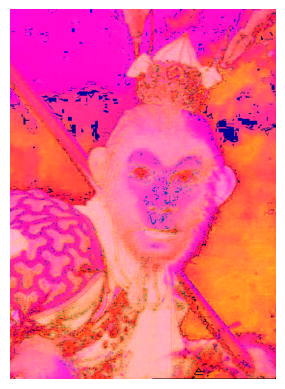

In [10]:
# rgb to hsv
imageWidth, imageHeight = rgb_image.shape[0], rgb_image.shape[1]
pixel_count = imageWidth * imageHeight
blockSize = 1024
gridSize = int(pixel_count / blockSize)

rgb_flat_gpu = rgb_image.reshape(pixel_count, 3)
rgb_flat_gpu.shape

start_time_gpu = time.time()
devSrc = cuda.to_device(rgb_flat_gpu)
devDst = cuda.device_array((pixel_count, 3), np.float32)
rgb2hsv[gridSize, blockSize](devSrc, devDst)
hostDst = devDst.copy_to_host()
gpu_time = time.time() - start_time_gpu

hsv_image = hostDst.reshape(imageWidth, imageHeight, 3)

plt.imshow(hsv_image)
plt.axis('off')
plt.show()

In [11]:
# hsv to rgb
hsv_image_flat = hsv_image.reshape(pixel_count, 3)

start_time_gpu = time.time()
devDst2 = cuda.device_array((pixel_count, 3), np.uint8)
hsv2rgb[gridSize, blockSize](devDst, devDst2)
hostDst = devDst2.copy_to_host()
gpu_time = time.time() - start_time_gpu

new_image_rgb = hostDst.reshape(imageWidth, imageHeight, 3)
plt.imshow(new_image_rgb)
plt.axis('off')
plt.show()

## HE

### HE GPU

In [12]:
v_channel = hsv_image[:,:,2]
v_channel

array([[0.8745098 , 0.8784314 , 0.88235295, ..., 0.5058824 , 0.2       ,
        0.05882353],
       [0.8784314 , 0.88235295, 0.8862745 , ..., 0.5529412 , 0.5254902 ,
        0.21960784],
       [0.88235295, 0.8862745 , 0.8901961 , ..., 0.4509804 , 0.6431373 ,
        0.46666667],
       ...,
       [0.1254902 , 0.18039216, 0.2784314 , ..., 0.10980392, 0.12941177,
        0.11764706],
       [0.07450981, 0.10588235, 0.16862746, ..., 0.11372549, 0.10980392,
        0.1254902 ],
       [0.1254902 , 0.11764706, 0.10980392, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

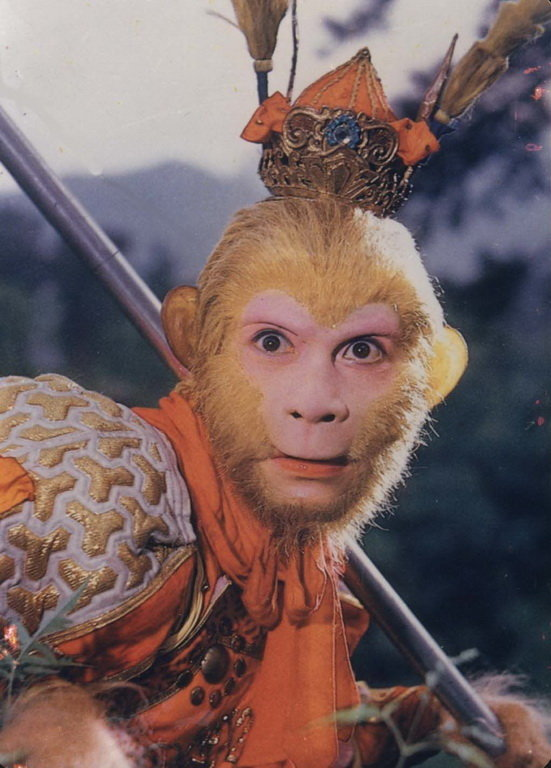

In [13]:
img

In [14]:
start_time = time.time()

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda

# dr lilian code for histogram
@cuda.jit(device=True, cache=True)
def init_histogram(d_histogram):
    tid = cuda.threadIdx.x
    while tid < histo_size:
        d_histogram[tid] = 0
        tid += cuda.blockDim.x

@cuda.jit(device=True, cache=True)
def init_shared_memory(shared_memory):
    tid = cuda.threadIdx.x
    while tid < histo_size:
        shared_memory[tid] = 0
        tid += cuda.blockDim.x

@cuda.jit(device=True, cache=True)
def histo_op(pixel_value):
    return pixel_value // bin_width

@cuda.jit(device=True, cache=True)
def save_shared_memory(shared_memory, d_histo):
  tid = cuda.threadIdx.x
  cuda.syncthreads()
  while tid < histo_size:
    cuda.atomic.add(d_histo, tid, shared_memory[tid])
    tid += cuda.blockDim.x

@cuda.jit
def gpu_histogram(d_input, d_histogram):
  shared_memory = cuda.shared.array(shape=histo_size, dtype=np_type)
  init_histogram(d_histogram)
  init_shared_memory(shared_memory)

  tid = cuda.grid(1)
  gridDim = cuda.gridDim.x * cuda.blockDim.x
  while tid < d_input.size:
    bin = histo_op(d_input[tid])
    cuda.atomic.add(shared_memory, bin, 1)
    tid += gridDim

  save_shared_memory(shared_memory, d_histogram)

histo_size = 256
np_type = np.int64
bin_width = 1
v_channel = hsv_image[:, :, 2]
img = (v_channel.flatten() * 255).astype(np.int64)

d_input = cuda.to_device(img)
d_histogram = cuda.to_device(np.zeros(histo_size, dtype=np.int64))

block_size = 128
grid_size = (img.size + block_size - 1) // block_size

gpu_histogram[grid_size, block_size](d_input, d_histogram)


h_histogram = d_histogram.copy_to_host()
plt.bar(range(histo_size), h_histogram)
plt.title('Histogram of Scaled V Channel in HSV Image')
plt.ylabel('Frequency')


plt.show()


In [16]:
import numpy as np
from numba import jit
import matplotlib.pyplot as plt

@jit(nopython=True)
def calculate_cdf(hist):
    cdf = np.empty_like(hist, dtype=np.float64)
    cdf[0] = hist[0]

    for i in range(1, len(hist)):
        cdf[i] = cdf[i - 1] + hist[i]

    max_cdf = cdf[-1]

    for i in range(len(hist)):
        cdf[i] /= max_cdf

    return cdf

cdf_result = calculate_cdf(h_histogram)
print("Original Histogram:", h_histogram)
print("CDF Result:", cdf_result)

plt.plot(range(len(h_histogram)), cdf_result)
plt.title('Normalized Cumulative Distribution Function (CDF)')
plt.xlabel('Pixel Value')
plt.ylabel('Normalized Cumulative Probability')

plt.show()


Original Histogram: [256   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   1   1   0   0   0   2   5   5   7  21  42  61  97 139 142 175 169
 170 170 116 118 136 141 117 119 123 140 122 119 159 127 126 137 159 137
 138 137 144 111 144 148 164 174 172 174 160 142 132 146 134 112 116 112
 115 116 110 119 115 121 119 126 127 137 158 143 143 157 156 138 155 152
 147 150 165 165 163 146 171 145 125 145 159 161 155 135 168 150 160 154
 150 169 166 179 152 139 175 184 174 172 166 156 167 150 162 147 145 138
 151 125 132 130 127 118 114 116 114 124 127 132 140 124 149 132 138 117
 144 166 167 190 170 202 206 207 241 248 228 249 235 226 189 231 187 238
 223 277 227 225 209 263 236 268 309 308 345 401 374 334 275 239 214 158
 135 114  79  93  94  66  66  68  43  61  48  42  59  56  70  57  59  56
  65  51  45  39  37  43  46  54  48  48  41  40  35  27  20  16  16  10
   9  18  16  14   3   1   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   

In [17]:
@cuda.jit
def map_to_cdf_kernel(v_channel, cdf, result):
    id = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x

    if id < len(v_channel):
        result[id] = cdf[v_channel[id]]

# block_size = 128
# grid_size = (len(v_channel) + block_size - 1) // block_size

d_input = cuda.to_device(img)
cdf = cuda.to_device(cdf_result)
result_np = cuda.to_device(np.zeros(len(img), dtype=np.float32))

map_to_cdf_kernel[grid_size, block_size](d_input, cdf, result_np)

result_v = result_np.copy_to_host()
result_v_new = result_v.reshape(hsv_image[:,:,2].shape)

hsv_image[:, :, 2] = result_v_new

In [18]:
# hsv to rgb
hsv_image_flat = hsv_image.reshape(pixel_count, 3)

start_time_gpu = time.time()
devDst2 = cuda.device_array((pixel_count, 3), np.uint8)
hsv2rgb[gridSize, blockSize](hsv_image_flat, devDst2)
hostDst = devDst2.copy_to_host()
gpu_time = time.time() - start_time_gpu

new_image_rgb = hostDst.reshape(imageWidth, imageHeight, 3)
plt.imshow(new_image_rgb)
plt.axis('off')
plt.show()

/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:886: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


In [19]:
time.time() - start_time

2.093289852142334

In [20]:
new_image_rgb.shape

(768, 551, 3)

### test code

In [21]:
# import numpy as np
# import matplotlib.pyplot as plt
# from numba import cuda
# from numba import jit

# @cuda.jit(device=True, cache=True)
# def init_histogram(d_histogram):
#     tid = cuda.threadIdx.x
#     while tid < histo_size:
#         d_histogram[tid] = 0
#         tid += cuda.blockDim.x

# @cuda.jit(device=True, cache=True)
# def init_shared_memory(shared_memory):
#     tid = cuda.threadIdx.x
#     while tid < histo_size:
#         shared_memory[tid] = 0
#         tid += cuda.blockDim.x

# @cuda.jit(device=True, cache=True)
# def histo_op(pixel_value):
#     return pixel_value // bin_width

# @cuda.jit(device=True, cache=True)
# def save_shared_memory(shared_memory, d_histo):
#   tid = cuda.threadIdx.x
#   cuda.syncthreads()
#   while tid < histo_size:
#     cuda.atomic.add(d_histo, tid, shared_memory[tid])
#     tid += cuda.blockDim.x

# @cuda.jit
# def gpu_histogram(d_input, d_histogram):
#   shared_memory = cuda.shared.array(shape=histo_size, dtype=np_type)
#   init_histogram(d_histogram)
#   init_shared_memory(shared_memory)

#   tid = cuda.grid(1)
#   gridDim = cuda.gridDim.x * cuda.blockDim.x
#   while tid < d_input.size:
#     bin = histo_op(d_input[tid])
#     cuda.atomic.add(shared_memory, bin, 1)
#     tid += gridDim

#   save_shared_memory(shared_memory, d_histogram)

# histo_size = 256
# np_type = np.int64
# bin_width = 1
# v_channel = hsv_image[:, :, 2]
# img = (v_channel.flatten() * 255).astype(np.int64)

# d_input = cuda.to_device(img)
# d_histogram = cuda.to_device(np.zeros(histo_size, dtype=np.int64))

# block_size = 128
# grid_size = (img.size + block_size - 1) // block_size

# gpu_histogram[grid_size, block_size](d_input, d_histogram)

# h_histogram = d_histogram.copy_to_host()

# plt.bar(range(histo_size), h_histogram)
# plt.title('Histogram of Scaled V Channel in HSV Image')
# plt.ylabel('Frequency')

# plt.show()
# # ===================================================
# @jit(nopython=True)
# def calculate_cdf(hist):
#     cdf = np.empty_like(hist, dtype=np.float64)
#     cdf[0] = hist[0]

#     for i in range(1, len(hist)):
#         cdf[i] = cdf[i - 1] + hist[i]

#     max_cdf = cdf[-1]

#     for i in range(len(hist)):
#         cdf[i] /= max_cdf

#     return cdf

# cdf_result = calculate_cdf(h_histogram)
# print("Original Histogram:", h_histogram)
# print("CDF Result:", cdf_result)

# plt.plot(range(len(h_histogram)), cdf_result)
# plt.title('Normalized Cumulative Distribution Function (CDF)')
# plt.xlabel('Pixel Value')
# plt.ylabel('Normalized Cumulative Probability')

# plt.show()
# @cuda.jit
# def map_to_cdf_kernel(v_channel, cdf, result):
#     id = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x

#     if id < len(v_channel):
#         result[id] = cdf[v_channel[id]]

# d_input = cuda.to_device(img)
# cdf = cuda.to_device(cdf_result)
# result_np = cuda.to_device(np.zeros(len(img), dtype=np.float32))

# map_to_cdf_kernel[grid_size, block_size](d_input, cdf, result_np)

# result_v = result_np.copy_to_host()
# result_v_new = result_v.reshape(hsv_image[:,:,2].shape)

# hsv_image[:, :, 2] = result_v_new
# hsv_image_flat = hsv_image.reshape(pixel_count, 3)

# start_time_gpu = time.time()
# devDst2 = cuda.device_array((pixel_count, 3), np.uint8)
# hsv2rgb[gridSize, blockSize](hsv_image_flat, devDst2)
# hostDst = devDst2.copy_to_host()
# gpu_time = time.time() - start_time_gpu

# new_image_rgb = hostDst.reshape(imageWidth, imageHeight, 3)
# plt.imshow(new_image_rgb)
# plt.axis('off')
# plt.show()

## The metrics

### AME

In [22]:
# AME (Average Mean Error)

@cuda.jit
def calculate_ame(image1, image2, result):
  id = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x

  if id < image1.size:
    abs_diff = image1[id] - image2[id]
    if abs_diff < 0:
      abs_diff = -abs_diff
    result[id] = abs_diff

d_v_result = cuda.to_device(result_v)
d_v_origin = cuda.to_device(img)
result_np = cuda.to_device(np.zeros(len(d_v_result), dtype=np.float32))

calculate_ame[grid_size, block_size](d_v_result, d_v_origin, result_np)

result_ame = result_np.copy_to_host()

In [23]:
from __future__ import annotations

import numpy as np
from numba.np.numpy_support import from_dtype
from numba import cuda, core


class AssociativeReduce(object):
    """Create a reduction object that reduces values using a given binary
    function. The binary function is compiled once and cached inside this
    object. Keeping this object alive will prevent re-compilation.
    """

    _cache = {}

    _WARP_SIZE = 32
    _NUM_WARPS = 8

    @staticmethod
    def _gpu_kernel_factory(fn, np_type):
        """Factory of kernels for the reduction problem...

        This function returns a Cuda Kernel that does the reduction of some data using a given binary functor."""

        reduce_op = cuda.jit(device=True)(fn)

        max_block_size = AssociativeReduce._NUM_WARPS * AssociativeReduce._WARP_SIZE

        @cuda.jit(device=True)
        def load_shared_memory(shared_memory, arr, null_value):
            global_tid = cuda.grid(1)
            local_tid = cuda.threadIdx.x
            # TODO: same as first exercise
            shared_memory[local_tid] = arr[global_tid] if global_tid < arr.size else null_value
            # wait all warps
            cuda.syncthreads()

        @cuda.jit(device=True)
        def reduce_per_warp(shared_memory):
            # warp_id = cuda.threadIdx.x // 32
            # in_warp_id = cuda.threadIdx.x % 32
            # # TODO: implement the pointer jumping without synchronization
            # # if right < max_block_size: # or cuda.blockDim.x
            # #   temp = shared_memory[right]
            # # else:
            # #   temp = shared_memory[local_tid]
            # # cuda.syncthreads()

            # temp = shared_memory[32*warp_id + in_warp_id]

            # # if right < max_block_size:
            # #   shared_memory[local_tid] = reduce_op(shared_memory[local_tid], temp)

            # shared_memory[32*warp_id + in_warp_id] = reduce_op(shared_memory[32*warp_id + in_warp_id], temp)
            # # cuda.syncthreads()

            tid = cuda.threadIdx.x
            in_warp_id = tid & 31 # what does this mean | chia lay du?

            jump = 1

            while jump < 32: # less than the side of the warp
              if in_warp_id + jump < 32:
                temp = shared_memory[tid+jump]
              cuda.syncwarp() # not syncthread but warp |
              if in_warp_id + jump < 32:
                shared_memory[tid] = reduce_op(shared_memory[tid], temp)
              cuda.syncwarp()
              jump = jump * 2


        def gpu_reduce_block(arr, partials, null_value):
            """
            Per block reduction, basic version...
            """
            # move data to shared memory
            shared_memory = cuda.shared.array(shape=max_block_size, dtype=np_type)
            load_shared_memory(shared_memory, arr, null_value)

            # TODO: implements the logics
            reduce_per_warp(shared_memory)
            cuda.syncthreads()

            if cuda.threadIdx.x >= 32: return

            to_warp = cuda.threadIdx.x * 32 # each 0 idx in each warp has the distance of 32

            shared_memory[cuda.threadIdx.x] = shared_memory[to_warp] if to_warp < cuda.blockDim.x else null_value # blockDim

            reduce_per_warp(shared_memory)
            # now stores the result
            if cuda.threadIdx.x == 0:
                blk_id = cuda.blockIdx.x
                partials[blk_id] = shared_memory[0]

        return cuda.jit(gpu_reduce_block)

    def __init__(self, functor):
        """
        :param functor: A function implementing a binary operation for
                        reduction. It will be compiled as a CUDA device
                        function using ``cuda.jit(device=True)``.
        """
        self._functor = functor

    def _compile(self, dtype):
        key = self._functor, dtype
        if key not in self._cache:
            self._cache[key] = AssociativeReduce._gpu_kernel_factory(self._functor, from_dtype(dtype))
        return self._cache[key]

    def __call__(self, arr, null_value, res=None, stream=cuda.default_stream()):
        """Performs a full reduction.

        :param arr: A host or device array.
        :param null_value: zero value for array.dtype
        :param res: Device array into which to write the reduction
                    result to. The result is written into the first element of
                    this array if this array is provided.
        :param stream: Optional CUDA stream in which to perform the reduction.
                    If no stream is specified, the default stream of 0 is
                    used.
        """

        # ensure 1d array
        if arr.ndim != 1:
            raise TypeError("only support 1D array")

        # ensure size > 0
        if arr.size < 1:
            raise ValueError("array's length is 0")

        _sav, core.config.CUDA_LOW_OCCUPANCY_WARNINGS = core.config.CUDA_LOW_OCCUPANCY_WARNINGS, False

        kernel = self._compile(arr.dtype)

        # Perform the reduction on the GPU
        start_event = cuda.event(True)
        start_event.record(stream=stream)
        nb_threads = self._NUM_WARPS * self._WARP_SIZE
        #=================================
        # the computation is different so we need this part:
        if True:
          if nb_threads > arr.size:
            nb_threads = arr.size
          nb_blocks = (arr.size + nb_threads - 1) // nb_threads

          temp = cuda.device_array(shape=nb_blocks, dtype=arr.dtype, stream=stream)
          kernel[nb_blocks, nb_threads, stream](arr, temp, null_value)
        # Perform the reduction on the GPU
        start_event = cuda.event(True)
        start_event.record(stream=stream)
        #=================================
        while True:
            if nb_threads > arr.size:
                nb_threads = arr.size

            nb_blocks = (arr.size + nb_threads - 1) // nb_threads

            temp = cuda.device_array(shape=nb_blocks, dtype=arr.dtype, stream=stream)

            kernel[nb_blocks, nb_threads, stream](arr, temp, null_value)
            print(f"launch {nb_blocks} for {nb_threads * nb_blocks} threads")
            cuda.synchronize()
            arr = temp
            if nb_blocks == 1:
                break

        stop_event = cuda.event(True)
        stop_event.record(stream=stream)
        stop_event.synchronize()
        ct = cuda.event_elapsed_time(start_event, stop_event)
        print(f"kernel computation time is {ct} ms")

        # handle return value
        if res is not None:
            res.copy_to_device(arr)

        core.config.CUDA_LOW_OCCUPANCY_WARNINGS = _sav

        return arr.copy_to_host(stream=stream)[0]


reducer = AssociativeReduce(lambda a, b: a + b)
h_array = result_ame
result = reducer(cuda.to_device(h_array), np.float32(0.0))


launch 1653 for 423168 threads
launch 7 for 1792 threads
launch 1 for 7 threads
kernel computation time is 2.7627201080322266 ms


In [24]:
result

55996796.0

it shown that the number return from my previous answer is incorrect?

In [25]:
np.sum(result_ame)

53485710.0

### Entropy


In [26]:
%%html
<iframe src="https://drive.google.com/file/d/1DblZgoOR0OoLJoBCh5uSTlAa6v8nOauv/preview" width="640" height="480" allow="autoplay"></iframe>

In [27]:
import numpy as np

def calculate_entropy(hist):

  entropy = 0.0
  for i in range(len(hist)):
    if hist[i] > 0:
      entropy += hist[i] * np.log2(hist[i])

  return -entropy

In [28]:
import numpy as np

def calculate_entropy_using_pdf(hist):

  pdf = hist / hist.sum()

  pdf[pdf == 0] = 1e-15

  entropy = 0.0
  for i in range(len(hist)):
    entropy += pdf[i] * np.log2(pdf[i])

  return -entropy

entropy = calculate_entropy_using_pdf(h_histogram)

print("Entropy:", entropy)

Entropy: 7.414580880353526


# Day 2

## set up

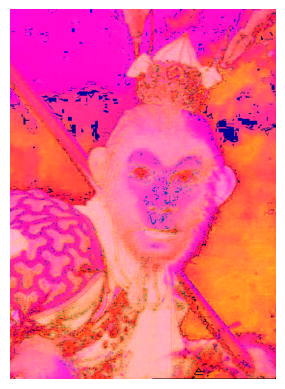

In [29]:
import numpy as np
import numba
from numba import cuda
import matplotlib.pyplot as plt
from matplotlib.image import imread
import time
import PIL
from PIL import Image
import requests
from io import BytesIO

# response = requests.get("https://i.pinimg.com/736x/a1/2f/27/a12f27921ca793258f90938b29240279.jpg")
response = requests.get("https://static.tuoitre.vn/tto/i/s626/2016/01/20/luc-tieu-linh-dong-resize-1453276183.jpg")

img = Image.open(BytesIO(response.content))

img_array = np.array(img)

img_array = img_array.reshape((img.height, img.width, 3))

rgb_image = img_array[:, :, :]

from numba.typed import List

#scale image [0..255] to [0..1]
@cuda.jit(nopython=True)
def scale(x):
  x = x/255
  return x

#find max and min
@cuda.jit(nopython=True)
def min_and_max(red, green, blue, src):
  #find max
  if red > green and red > blue:
    max_c = (red, 0)
  elif green > red and green > blue:
    max_c = (green, 1)
  else:
    max_c = (blue, 2)

  #find min
  if red < green and red < blue:
    min_c = (red, 0)
  elif green < red and green < blue:
    min_c = (green, 1)
  else:
    min_c = (blue, 2)

  delta = max_c[0] - min_c[0]

  return (max_c, min_c, delta)

@cuda.jit
def rgb2hsv(src, dst):
    tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    g = np.float32(((src[tidx, 0] + src[tidx, 1] + src[tidx, 2]) / 3))

    red = scale(np.float32(src[tidx, 0]))
    green = scale(np.float32(src[tidx, 1]))
    blue = scale(np.float32(src[tidx, 2]))

    # min_c, max_c, delta = min_and_max(red, green, blue, src)
    max_c, min_c, delta = min_and_max(red, green, blue, src)
    H = 0
    S = 0
    V = 0
    if delta == 0:
      H = 0
    elif max_c[1] == 0:
      H = 60*(((green-blue)/delta)%6)
    elif max_c[1] == 1:
      H = 60*(((blue-red)/delta)+2)
    else:
      H = 60*(((red-green)/delta)+4)

    if max_c[0] == 0:
      S = 0
    else:
      S = delta/max_c[0]

    V = max_c[0]

    dst[tidx, 0] = H
    dst[tidx, 1] = S
    dst[tidx, 2] = V

@cuda.jit
def hsv2rgb(src, dst):
    tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x

    H = src[tidx, 0]
    S = src[tidx, 1]
    V = src[tidx, 2]

    d = H/60
    hi = int(d)%6
    f = d - hi

    l = V*(1-S)
    m = V*(1-f*S)
    n = V*(1-(1-f)*S)

    if H>=0 and H < 60:
      first_c = V
      second_c = n
      third_c = l
    elif H >= 60 and H < 120:
      first_c = m
      second_c = V
      third_c = l
    elif H >= 120 and H < 180:
      first_c = l
      second_c = V
      third_c = n
    elif H >= 180 and H < 240:
      first_c = l
      second_c = m
      third_c = V
    elif H >= 240 and H < 300:
      first_c = n
      second_c = l
      third_c = V
    else:
      first_c = V
      second_c = l
      third_c = m
    #dst[tidx, 0] = 255
    #dst[tidx, 1] = 128
    #dst[tidx, 2] = 128
    dst[tidx, 0] = first_c*255
    dst[tidx, 1] = second_c*255
    dst[tidx, 2] = third_c*255

# rgb to hsv
imageWidth, imageHeight = rgb_image.shape[0], rgb_image.shape[1]
pixel_count = imageWidth * imageHeight
blockSize = 1024
gridSize = int(pixel_count / blockSize)

rgb_flat_gpu = rgb_image.reshape(pixel_count, 3)
rgb_flat_gpu.shape

start_time_gpu = time.time()
devSrc = cuda.to_device(rgb_flat_gpu)
devDst = cuda.device_array((pixel_count, 3), np.float32)
rgb2hsv[gridSize, blockSize](devSrc, devDst)
hostDst = devDst.copy_to_host()
gpu_time = time.time() - start_time_gpu

hsv_image = hostDst.reshape(imageWidth, imageHeight, 3)

plt.imshow(hsv_image)
plt.axis('off')
plt.show()

# hsv to rgb
hsv_image_flat = hsv_image.reshape(pixel_count, 3)

start_time_gpu = time.time()
devDst2 = cuda.device_array((pixel_count, 3), np.uint8)
hsv2rgb[gridSize, blockSize](devDst, devDst2)
hostDst = devDst2.copy_to_host()
gpu_time = time.time() - start_time_gpu

new_image_rgb = hostDst.reshape(imageWidth, imageHeight, 3)
plt.imshow(new_image_rgb)
plt.axis('off')
plt.show()

## AHE

In [30]:
start_time = time.time()

## AHE GPU

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
from numba import jit

@cuda.jit(device=True, cache=True)
def init_histogram(d_histogram):
    tid = cuda.threadIdx.x
    while tid < histo_size:
        d_histogram[tid] = 0
        tid += cuda.blockDim.x

@cuda.jit(device=True, cache=True)
def init_shared_memory(shared_memory):
    tid = cuda.threadIdx.x
    while tid < histo_size:
        shared_memory[tid] = 0
        tid += cuda.blockDim.x
#====================
@cuda.jit(device=True, cache=True)
def init_uniform_his(uni_his, size):
    tid = cuda.threadIdx.x
    while tid < histo_size:
        uni_his[tid] = size//256
        tid += cuda.blockDim.x
#====================
@cuda.jit(device=True, cache=True)
def histo_op(pixel_value):
    return pixel_value // bin_width

@cuda.jit(device=True, cache=True)
def save_shared_memory(shared_memory, d_histo):
  tid = cuda.threadIdx.x
  cuda.syncthreads()
  while tid < histo_size:
    cuda.atomic.add(d_histo, tid, shared_memory[tid])
    tid += cuda.blockDim.x

@cuda.jit
def gpu_histogram(d_input, d_histogram):
  shared_memory = cuda.shared.array(shape=histo_size, dtype=np_type)
  init_histogram(d_histogram)
  init_shared_memory(shared_memory)

  tid = cuda.grid(1)
  gridDim = cuda.gridDim.x * cuda.blockDim.x
  while tid < d_input.size:
    bin = histo_op(d_input[tid])
    cuda.atomic.add(shared_memory, bin, 1)
    tid += gridDim

  save_shared_memory(shared_memory, d_histogram)

histo_size = 256
np_type = np.int64
bin_width = 1
v_channel = hsv_image[:, :, 2]
v_c = (v_channel.flatten() * 255).astype(np.int64)

d_input = cuda.to_device(v_c)
d_histogram = cuda.to_device(np.zeros(histo_size, dtype=np.int64))
d_uni = cuda.to_device(np.zeros(histo_size, dtype=np.int64))

block_size = 128
grid_size = (v_c.size + block_size - 1) // block_size

gpu_histogram[grid_size, block_size](d_input, d_histogram)

h_histogram = d_histogram.copy_to_host()

plt.bar(range(histo_size), h_histogram)
plt.title('Histogram of Scaled V Channel in HSV Image')
plt.ylabel('Frequency')

plt.show()

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 2 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


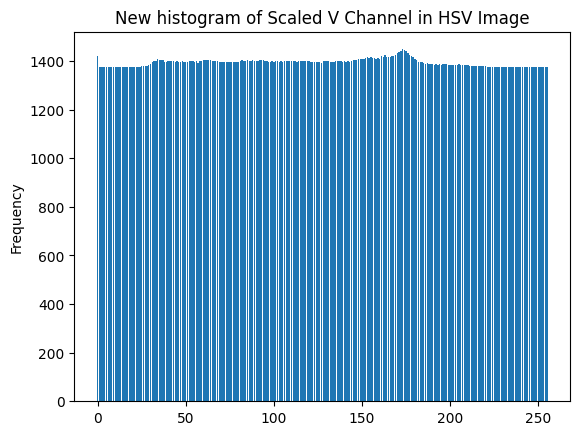

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda

@cuda.jit(device=True, cache=True)
def init_uniform_his(uni_his, size):
    tid = cuda.threadIdx.x
    while tid < histo_size:
        uni_his[tid] = size // 256
        tid += cuda.blockDim.x

@cuda.jit(device=True, cache=True)
def init_new_histogram(d_histogram_new):
    tid = cuda.threadIdx.x
    while tid < histo_size:
        d_histogram_new[tid] = 0
        tid += cuda.blockDim.x

@cuda.jit
def gpu_new_histogram(d_input, d_histogram, d_uni, d_histogram_new, lamb):
    init_uniform_his(d_uni, len(d_input))
    init_new_histogram(d_histogram_new)

    tid = cuda.grid(1)
    gridDim = cuda.gridDim.x * cuda.blockDim.x

    cuda.syncthreads()

    while tid < d_histogram.size:
        d_histogram_new[tid] = (1 / (1 + lamb)) * d_histogram[tid] + (lamb / (1 + lamb)) * d_uni[tid]
        tid += gridDim

    cuda.syncthreads()

histo_size = 256
np_type = np.int64
bin_width = 1
lamb = 5

d_input = cuda.to_device(v_c)
d_histogram = cuda.to_device(h_histogram)
d_uni = cuda.to_device(np.zeros(histo_size, dtype=np.int64))
d_histogram_new = cuda.to_device(np.zeros(histo_size, dtype=np.int64))

block_size = 128
grid_size_new = (d_histogram.size + block_size - 1) // block_size

gpu_new_histogram[grid_size_new, block_size](d_input, d_histogram, d_uni, d_histogram_new, lamb)

h_histogram_new = d_histogram_new.copy_to_host()
h_uni = d_uni.copy_to_host()

plt.bar(range(histo_size), h_histogram_new)
plt.title('New histogram of Scaled V Channel in HSV Image')
plt.ylabel('Frequency')
plt.show()


Original Histogram: [1420 1377 1377 1377 1377 1377 1377 1377 1377 1377 1377 1377 1377 1377
 1377 1377 1377 1377 1377 1377 1377 1377 1377 1377 1377 1378 1378 1378
 1381 1384 1387 1395 1400 1400 1406 1405 1405 1405 1396 1397 1400 1400
 1398 1398 1397 1398 1394 1396 1401 1394 1395 1397 1400 1398 1398 1396
 1400 1393 1398 1400 1403 1404 1402 1404 1403 1400 1399 1400 1398 1394
 1396 1395 1395 1396 1394 1396 1395 1396 1396 1397 1397 1398 1402 1400
 1399 1402 1401 1398 1403 1401 1400 1401 1403 1403 1403 1401 1398 1397
 1396 1399 1397 1398 1399 1396 1400 1397 1399 1398 1398 1400 1400 1399
 1401 1397 1400 1401 1401 1399 1398 1398 1398 1396 1396 1395 1395 1396
 1396 1392 1399 1398 1398 1398 1397 1396 1396 1399 1400 1399 1400 1397
 1399 1395 1398 1396 1400 1402 1403 1404 1406 1410 1409 1409 1414 1416
 1413 1418 1412 1412 1406 1414 1409 1421 1415 1425 1418 1415 1415 1422
 1420 1426 1432 1435 1442 1448 1446 1440 1433 1425 1420 1416 1408 1403
 1395 1396 1395 1391 1389 1390 1387 1388 1386 1385 1386 1

This is the v_c:  (array([  0,  15,  16,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
       145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
       184, 185, 186, 187, 188, 189, 190, 191

/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:886: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


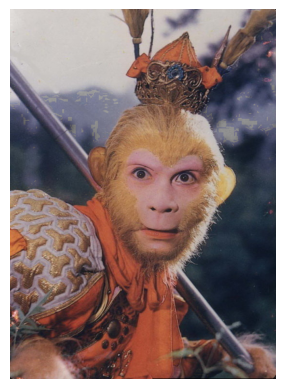

In [33]:
# ===================================================
@jit(nopython=True)
def calculate_cdf_new(hist):
    cdf = np.empty_like(hist, dtype=np.float64)
    cdf[0] = hist[0]

    for i in range(1, len(hist)):
        cdf[i] = cdf[i - 1] + hist[i]

    max_cdf = cdf[-1]

    for i in range(len(hist)):
        cdf[i] /= max_cdf

    return cdf

# cdf_result = calculate_cdf_new(h_histogram_new)
cdf_result = calculate_cdf_new(h_histogram_new)
print("Original Histogram:", h_histogram_new)
print("CDF Result:", cdf_result)

plt.plot(range(len(h_histogram_new)), cdf_result)
plt.title('Normalized Cumulative Distribution Function (CDF)')
plt.xlabel('Pixel Value')
plt.ylabel('Normalized Cumulative Probability')

plt.show()

@cuda.jit
def map_to_cdf_kernel(v_channel, cdf, result_np):
    id = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    cuda.syncthreads()

    if id < len(v_channel):
        # the error must be here:
        result_np[id] = cdf[v_channel[id]]
        # result_np[id] = memcpy_dto_h(cdf[v_channel[id]])
    cuda.syncthreads()


d_input = cuda.to_device(v_c)
print("This is the v_c: ", np.unique(v_c, return_counts = True))
cdf = cuda.to_device(cdf_result)
result_np = cuda.to_device(np.zeros(len(v_c), dtype=np.float32))
d_histogram_new = cuda.to_device(d_histogram_new)

map_to_cdf_kernel[grid_size, block_size](d_input, cdf, result_np)

result_v = result_np.copy_to_host()
result_v_new = result_v.reshape(hsv_image[:,:,2].shape)
result_v_new = np.clip(result_v_new, 0, 1)

hsv_image[:, :, 2] = result_v_new
hsv_image_flat = hsv_image.reshape(pixel_count, 3)

start_time_gpu = time.time()
devDst2 = cuda.device_array((pixel_count, 3), np.uint8)
hsv2rgb[gridSize, blockSize](hsv_image_flat, devDst2)
hostDst = devDst2.copy_to_host()
gpu_time = time.time() - start_time_gpu

new_image_rgb = hostDst.reshape(imageWidth, imageHeight, 3)
plt.imshow(new_image_rgb)
plt.axis('off')
plt.show()

In [34]:
time.time() - start_time

6.404929161071777

#### AHE metrics

In [35]:
# AME (Average Mean Error)

@cuda.jit
def calculate_ame(image1, image2, result):
  id = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x

  if id < image1.size:
    abs_diff = image1[id] - image2[id]
    if abs_diff < 0:
      abs_diff = -abs_diff
    result[id] = abs_diff

d_v_result = cuda.to_device(result_v)
v_c = (v_channel.flatten() * 255).astype(np.int64)
d_v_origin = cuda.to_device(v_c)
result_np = cuda.to_device(np.zeros(len(d_v_result), dtype=np.float32))

calculate_ame[grid_size, block_size](d_v_result, d_v_origin, result_np)

result_ame = result_np.copy_to_host()

In [36]:
from __future__ import annotations

import numpy as np
from numba.np.numpy_support import from_dtype
from numba import cuda, core


class AssociativeReduce(object):
    """Create a reduction object that reduces values using a given binary
    function. The binary function is compiled once and cached inside this
    object. Keeping this object alive will prevent re-compilation.
    """

    _cache = {}

    _WARP_SIZE = 32
    _NUM_WARPS = 8

    @staticmethod
    def _gpu_kernel_factory(fn, np_type):
        """Factory of kernels for the reduction problem...

        This function returns a Cuda Kernel that does the reduction of some data using a given binary functor."""

        reduce_op = cuda.jit(device=True)(fn)

        max_block_size = AssociativeReduce._NUM_WARPS * AssociativeReduce._WARP_SIZE

        @cuda.jit(device=True)
        def load_shared_memory(shared_memory, arr, null_value):
            global_tid = cuda.grid(1)
            local_tid = cuda.threadIdx.x
            # TODO: same as first exercise
            shared_memory[local_tid] = arr[global_tid] if global_tid < arr.size else null_value
            # wait all warps
            cuda.syncthreads()

        @cuda.jit(device=True)
        def reduce_per_warp(shared_memory):
            # warp_id = cuda.threadIdx.x // 32
            # in_warp_id = cuda.threadIdx.x % 32
            # # TODO: implement the pointer jumping without synchronization
            # # if right < max_block_size: # or cuda.blockDim.x
            # #   temp = shared_memory[right]
            # # else:
            # #   temp = shared_memory[local_tid]
            # # cuda.syncthreads()

            # temp = shared_memory[32*warp_id + in_warp_id]

            # # if right < max_block_size:
            # #   shared_memory[local_tid] = reduce_op(shared_memory[local_tid], temp)

            # shared_memory[32*warp_id + in_warp_id] = reduce_op(shared_memory[32*warp_id + in_warp_id], temp)
            # # cuda.syncthreads()

            tid = cuda.threadIdx.x
            in_warp_id = tid & 31 # what does this mean | chia lay du?

            jump = 1

            while jump < 32: # less than the side of the warp
              if in_warp_id + jump < 32:
                temp = shared_memory[tid+jump]
              cuda.syncwarp() # not syncthread but warp |
              if in_warp_id + jump < 32:
                shared_memory[tid] = reduce_op(shared_memory[tid], temp)
              cuda.syncwarp()
              jump = jump * 2


        def gpu_reduce_block(arr, partials, null_value):
            """
            Per block reduction, basic version...
            """
            # move data to shared memory
            shared_memory = cuda.shared.array(shape=max_block_size, dtype=np_type)
            load_shared_memory(shared_memory, arr, null_value)

            # TODO: implements the logics
            reduce_per_warp(shared_memory)
            cuda.syncthreads()

            if cuda.threadIdx.x >= 32: return

            to_warp = cuda.threadIdx.x * 32 # each 0 idx in each warp has the distance of 32

            shared_memory[cuda.threadIdx.x] = shared_memory[to_warp] if to_warp < cuda.blockDim.x else null_value # blockDim

            reduce_per_warp(shared_memory)
            # now stores the result
            if cuda.threadIdx.x == 0:
                blk_id = cuda.blockIdx.x
                partials[blk_id] = shared_memory[0]

        return cuda.jit(gpu_reduce_block)

    def __init__(self, functor):
        """
        :param functor: A function implementing a binary operation for
                        reduction. It will be compiled as a CUDA device
                        function using ``cuda.jit(device=True)``.
        """
        self._functor = functor

    def _compile(self, dtype):
        key = self._functor, dtype
        if key not in self._cache:
            self._cache[key] = AssociativeReduce._gpu_kernel_factory(self._functor, from_dtype(dtype))
        return self._cache[key]

    def __call__(self, arr, null_value, res=None, stream=cuda.default_stream()):
        """Performs a full reduction.

        :param arr: A host or device array.
        :param null_value: zero value for array.dtype
        :param res: Device array into which to write the reduction
                    result to. The result is written into the first element of
                    this array if this array is provided.
        :param stream: Optional CUDA stream in which to perform the reduction.
                    If no stream is specified, the default stream of 0 is
                    used.
        """

        # ensure 1d array
        if arr.ndim != 1:
            raise TypeError("only support 1D array")

        # ensure size > 0
        if arr.size < 1:
            raise ValueError("array's length is 0")

        _sav, core.config.CUDA_LOW_OCCUPANCY_WARNINGS = core.config.CUDA_LOW_OCCUPANCY_WARNINGS, False

        kernel = self._compile(arr.dtype)

        # Perform the reduction on the GPU
        start_event = cuda.event(True)
        start_event.record(stream=stream)
        nb_threads = self._NUM_WARPS * self._WARP_SIZE
        #=================================
        # the computation is different so we need this part:
        if True:
          if nb_threads > arr.size:
            nb_threads = arr.size
          nb_blocks = (arr.size + nb_threads - 1) // nb_threads

          temp = cuda.device_array(shape=nb_blocks, dtype=arr.dtype, stream=stream)
          kernel[nb_blocks, nb_threads, stream](arr, temp, null_value)
        # Perform the reduction on the GPU
        start_event = cuda.event(True)
        start_event.record(stream=stream)
        #=================================
        while True:
            if nb_threads > arr.size:
                nb_threads = arr.size

            nb_blocks = (arr.size + nb_threads - 1) // nb_threads

            temp = cuda.device_array(shape=nb_blocks, dtype=arr.dtype, stream=stream)

            kernel[nb_blocks, nb_threads, stream](arr, temp, null_value)
            print(f"launch {nb_blocks} for {nb_threads * nb_blocks} threads")
            cuda.synchronize()
            arr = temp
            if nb_blocks == 1:
                break

        stop_event = cuda.event(True)
        stop_event.record(stream=stream)
        stop_event.synchronize()
        ct = cuda.event_elapsed_time(start_event, stop_event)
        print(f"kernel computation time is {ct} ms")

        # handle return value
        if res is not None:
            res.copy_to_device(arr)

        core.config.CUDA_LOW_OCCUPANCY_WARNINGS = _sav

        return arr.copy_to_host(stream=stream)[0]


reducer = AssociativeReduce(lambda a, b: a + b)
h_array = result_ame
result = reducer(cuda.to_device(h_array), np.float32(0.0))
result

launch 1653 for 423168 threads
launch 7 for 1792 threads
launch 1 for 7 threads
kernel computation time is 3.581631898880005 ms


56020370.0

In [37]:
import numpy as np

def calculate_entropy(hist):

  entropy = 0.0
  for i in range(len(hist)):
    if hist[i] > 0:
      entropy += hist[i] * np.log2(hist[i])

  return -entropy

import numpy as np

def calculate_entropy_using_pdf(hist):

  pdf = hist / hist.sum()

  pdf[pdf == 0] = 1e-15

  entropy = 0.0
  for i in range(len(hist)):
    entropy += pdf[i] * np.log2(pdf[i])

  return -entropy

entropy = calculate_entropy_using_pdf(h_histogram)

print("Entropy:", entropy)

Entropy: 7.390038110370212


### test AHE CPU

In [38]:
    # if id < len(v_channel):
    #     # result[id] = cdf[v_channel[id]]
    #     # the error must be here: (1 / (1 + lamb)) * d_histogram[tid] + (lamb / (1 + lamb)) * d_uni[tid]
    #     result[id] = cdf[v_channel[id]]
    # cuda.syncthreads()

In [39]:
result_1 = np.zeros(len(v_c), dtype=np.float32)
for i in range(len(v_c)):
  result_1[i] = cdf_result[v_c[i]]

In [40]:
len(v_c)

423168

/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:886: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


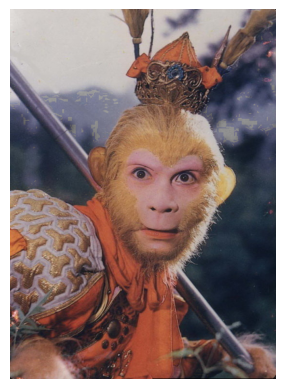

In [41]:
# result_v = result_np.copy_to_host()
result_v_new = result_1.reshape(hsv_image[:,:,2].shape)
# result_v_new = np.clip(result_v_new, 0, 1)

hsv_image[:, :, 2] = result_v_new
hsv_image_flat = hsv_image.reshape(pixel_count, 3)

start_time_gpu = time.time()
devDst2 = cuda.device_array((pixel_count, 3), np.uint8)
hsv2rgb[gridSize, blockSize](hsv_image_flat, devDst2)
hostDst = devDst2.copy_to_host()
gpu_time = time.time() - start_time_gpu

new_image_rgb = hostDst.reshape(imageWidth, imageHeight, 3)
plt.imshow(new_image_rgb)
plt.axis('off')
plt.show()

## WHE

In [42]:
%%html
<iframe src="https://drive.google.com/file/d/1r8K3bqw9irSCuLKpZb3zh34ydp7X4aCL/preview" width="640" height="480" allow="autoplay"></iframe>

### calculate the W matrix

In [43]:
import numpy as np

def get_W_matrix(image):

  neighbors_variance = np.zeros_like(image)
  for i in range(image.shape[0]):
    for j in range(image.shape[1]):
      neighbor = image[i - 1:i + 2, j - 1:j + 2]
      neighbor[np.isnan(neighbor)] = 0
      variance = np.var(neighbor)
      if np.isnan(variance):
          neighbors_variance[i, j] = 0
      else:
          neighbors_variance[i, j] = variance

  gray_levels = np.arange(256)
  pixel_groups = {}
  for i in range(gray_levels.shape[0]):
    pixel_groups[gray_levels[i]] = []

  for i in range(image.shape[0]):
    for j in range(image.shape[1]):
      pixel_groups[image[i, j]].append((i, j))

  W_matrix = np.zeros((gray_levels.shape[0], gray_levels.shape[0]))
  for gray_level in gray_levels:
    neighbors_variance_sum = 0
    for pixel in pixel_groups[gray_level]:
      neighbors_variance_sum += neighbors_variance[pixel[0], pixel[1]]
    # print(gray_level)
    W_matrix[gray_level, gray_level] = 0 if len(pixel_groups[gray_level]) == 0 else neighbors_variance_sum / len(pixel_groups[gray_level])

  return W_matrix

In [44]:
v_channel = hsv_image[:,:,2]

In [45]:
v_channel_int = (v_channel*255).astype(np.int32)
np.isnan(v_channel_int).any()

False

In [46]:
# there are 256 gray level in total

In [47]:
W_matrix = get_W_matrix(v_channel_int)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [48]:
W_matrix = W_matrix.astype(np.int64)

### take inversion of the first part

# Day 3

## set up

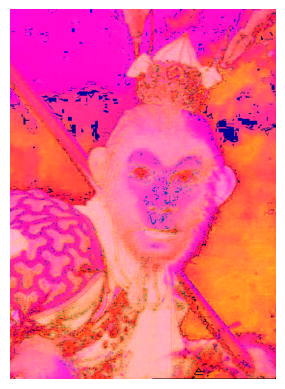

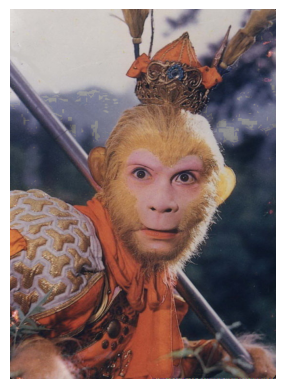

In [49]:
import numpy as np
import numba
from numba import cuda
import matplotlib.pyplot as plt
from matplotlib.image import imread
import time
import PIL
from PIL import Image
import requests
from io import BytesIO

# response = requests.get("https://i.pinimg.com/736x/a1/2f/27/a12f27921ca793258f90938b29240279.jpg")
response = requests.get("https://static.tuoitre.vn/tto/i/s626/2016/01/20/luc-tieu-linh-dong-resize-1453276183.jpg")

img = Image.open(BytesIO(response.content))

img_array = np.array(img)

img_array = img_array.reshape((img.height, img.width, 3))

rgb_image = img_array[:, :, :]

from numba.typed import List

#scale image [0..255] to [0..1]
@cuda.jit(nopython=True)
def scale(x):
  x = x/255
  return x

#find max and min
@cuda.jit(nopython=True)
def min_and_max(red, green, blue, src):
  #find max
  if red > green and red > blue:
    max_c = (red, 0)
  elif green > red and green > blue:
    max_c = (green, 1)
  else:
    max_c = (blue, 2)

  #find min
  if red < green and red < blue:
    min_c = (red, 0)
  elif green < red and green < blue:
    min_c = (green, 1)
  else:
    min_c = (blue, 2)

  delta = max_c[0] - min_c[0]

  return (max_c, min_c, delta)

@cuda.jit
def rgb2hsv(src, dst):
    tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    g = np.float32(((src[tidx, 0] + src[tidx, 1] + src[tidx, 2]) / 3))

    red = scale(np.float32(src[tidx, 0]))
    green = scale(np.float32(src[tidx, 1]))
    blue = scale(np.float32(src[tidx, 2]))

    # min_c, max_c, delta = min_and_max(red, green, blue, src)
    max_c, min_c, delta = min_and_max(red, green, blue, src)
    H = 0
    S = 0
    V = 0
    if delta == 0:
      H = 0
    elif max_c[1] == 0:
      H = 60*(((green-blue)/delta)%6)
    elif max_c[1] == 1:
      H = 60*(((blue-red)/delta)+2)
    else:
      H = 60*(((red-green)/delta)+4)

    if max_c[0] == 0:
      S = 0
    else:
      S = delta/max_c[0]

    V = max_c[0]

    dst[tidx, 0] = H
    dst[tidx, 1] = S
    dst[tidx, 2] = V

@cuda.jit
def hsv2rgb(src, dst):
    tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x

    H = src[tidx, 0]
    S = src[tidx, 1]
    V = src[tidx, 2]

    d = H/60
    hi = int(d)%6
    f = d - hi

    l = V*(1-S)
    m = V*(1-f*S)
    n = V*(1-(1-f)*S)

    if H>=0 and H < 60:
      first_c = V
      second_c = n
      third_c = l
    elif H >= 60 and H < 120:
      first_c = m
      second_c = V
      third_c = l
    elif H >= 120 and H < 180:
      first_c = l
      second_c = V
      third_c = n
    elif H >= 180 and H < 240:
      first_c = l
      second_c = m
      third_c = V
    elif H >= 240 and H < 300:
      first_c = n
      second_c = l
      third_c = V
    else:
      first_c = V
      second_c = l
      third_c = m
    #dst[tidx, 0] = 255
    #dst[tidx, 1] = 128
    #dst[tidx, 2] = 128
    dst[tidx, 0] = first_c*255
    dst[tidx, 1] = second_c*255
    dst[tidx, 2] = third_c*255

# rgb to hsv
imageWidth, imageHeight = rgb_image.shape[0], rgb_image.shape[1]
pixel_count = imageWidth * imageHeight
blockSize = 1024
gridSize = int(pixel_count / blockSize)

rgb_flat_gpu = rgb_image.reshape(pixel_count, 3)
rgb_flat_gpu.shape

start_time_gpu = time.time()
devSrc = cuda.to_device(rgb_flat_gpu)
devDst = cuda.device_array((pixel_count, 3), np.float32)
rgb2hsv[gridSize, blockSize](devSrc, devDst)
hostDst = devDst.copy_to_host()
gpu_time = time.time() - start_time_gpu

hsv_image = hostDst.reshape(imageWidth, imageHeight, 3)

plt.imshow(hsv_image)
plt.axis('off')
plt.show()

# hsv to rgb
hsv_image_flat = hsv_image.reshape(pixel_count, 3)

start_time_gpu = time.time()
devDst2 = cuda.device_array((pixel_count, 3), np.uint8)
hsv2rgb[gridSize, blockSize](devDst, devDst2)
hostDst = devDst2.copy_to_host()
gpu_time = time.time() - start_time_gpu

new_image_rgb = hostDst.reshape(imageWidth, imageHeight, 3)
plt.imshow(new_image_rgb)
plt.axis('off')
plt.show()

In [50]:
start_time = time.time()

## Exposure threshold calculation

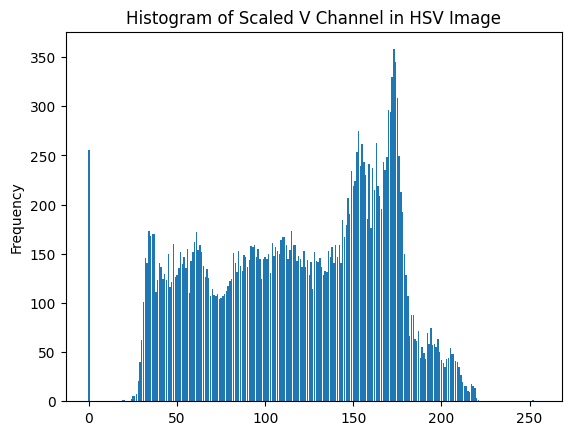

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
from numba import jit

@cuda.jit(device=True, cache=True)
def init_histogram(d_histogram):
    tid = cuda.threadIdx.x
    while tid < histo_size:
        d_histogram[tid] = 0
        tid += cuda.blockDim.x

@cuda.jit(device=True, cache=True)
def init_shared_memory(shared_memory):
    tid = cuda.threadIdx.x
    while tid < histo_size:
        shared_memory[tid] = 0
        tid += cuda.blockDim.x
#====================
@cuda.jit(device=True, cache=True)
def init_uniform_his(uni_his, size):
    tid = cuda.threadIdx.x
    while tid < histo_size:
        uni_his[tid] = size//256
        tid += cuda.blockDim.x
#====================
@cuda.jit(device=True, cache=True)
def histo_op(pixel_value):
    return pixel_value // bin_width

@cuda.jit(device=True, cache=True)
def save_shared_memory(shared_memory, d_histo):
  tid = cuda.threadIdx.x
  cuda.syncthreads()
  while tid < histo_size:
    cuda.atomic.add(d_histo, tid, shared_memory[tid])
    tid += cuda.blockDim.x

@cuda.jit
def gpu_histogram(d_input, d_histogram):
  shared_memory = cuda.shared.array(shape=histo_size, dtype=np_type)
  init_histogram(d_histogram)
  init_shared_memory(shared_memory)

  tid = cuda.grid(1)
  gridDim = cuda.gridDim.x * cuda.blockDim.x
  while tid < d_input.size:
    bin = histo_op(d_input[tid])
    cuda.atomic.add(shared_memory, bin, 1)
    tid += gridDim

  save_shared_memory(shared_memory, d_histogram)

histo_size = 256
np_type = np.int64
bin_width = 1
v_channel = hsv_image[:, :, 2]
v_c = (v_channel.flatten() * 255).astype(np.int64)

d_input = cuda.to_device(v_c)
d_histogram = cuda.to_device(np.zeros(histo_size, dtype=np.int64))
d_uni = cuda.to_device(np.zeros(histo_size, dtype=np.int64))

block_size = 128
grid_size = (v_c.size + block_size - 1) // block_size

gpu_histogram[grid_size, block_size](d_input, d_histogram)

h_histogram = d_histogram.copy_to_host()

plt.bar(range(histo_size), h_histogram)
plt.title('Histogram of Scaled V Channel in HSV Image')
plt.ylabel('Frequency')

plt.show()

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
from numba import jit

@cuda.jit
def gpu_exposure(d_histogram, d_exposure_up, d_exposure_down, d_exposure, histo_size):

  tid = cuda.threadIdx.x
  gridDim = cuda.gridDim.x * cuda.blockDim.x

  while tid < histo_size:
    d_exposure_up[0] += (tid * d_histogram[tid])
    d_exposure_down[0] += d_histogram[tid]

    tid += gridDim
  cuda.syncthreads()
  d_exposure[0] = (d_exposure_up[0]/d_exposure_down[0])/histo_size

histo_size = 256
np_type = np.int64

v_channel = hsv_image[:, :, 2]
v_c = (v_channel.flatten() * 255).astype(np.int64)

d_histogram = cuda.to_device(h_histogram)
d_exposure_up = cuda.to_device(np.zeros(1, dtype=np.float64))
d_exposure_down = cuda.to_device(np.zeros(1, dtype=np.float64))

d_exposure = cuda.to_device(np.zeros(1, dtype=np.float64))

block_size = 128
grid_size = (histo_size + block_size - 1) // block_size

gpu_exposure[grid_size, block_size](d_histogram, d_exposure_up, d_exposure_down, d_exposure, histo_size)

exposure_up = d_exposure_up.copy_to_host()
exposure_down = d_exposure_down.copy_to_host()
exposure = d_exposure.copy_to_host()

print('Exposure up:', exposure_up)
print('Exposure down:', exposure_down)

print('Exposure:', exposure)


Exposure up: [17808.]
Exposure down: [159.]
Exposure: [0.4375]


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 2 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [53]:
x_a = histo_size*(1-exposure)
x_a

array([144.])

## Histogram cliping

### Calculate the threshold

In [54]:
from __future__ import annotations

import numpy as np
from numba.np.numpy_support import from_dtype
from numba import cuda, core


class AssociativeReduce(object):
    """Create a reduction object that reduces values using a given binary
    function. The binary function is compiled once and cached inside this
    object. Keeping this object alive will prevent re-compilation.
    """

    _cache = {}

    _WARP_SIZE = 32
    _NUM_WARPS = 8

    @staticmethod
    def _gpu_kernel_factory(fn, np_type):
        """Factory of kernels for the reduction problem...

        This function returns a Cuda Kernel that does the reduction of some data using a given binary functor."""

        reduce_op = cuda.jit(device=True)(fn)

        max_block_size = AssociativeReduce._NUM_WARPS * AssociativeReduce._WARP_SIZE

        @cuda.jit(device=True)
        def load_shared_memory(shared_memory, arr, null_value):
            global_tid = cuda.grid(1)
            local_tid = cuda.threadIdx.x
            # TODO: same as first exercise
            shared_memory[local_tid] = arr[global_tid] if global_tid < arr.size else null_value
            # wait all warps
            cuda.syncthreads()

        @cuda.jit(device=True)
        def reduce_per_warp(shared_memory):
            # warp_id = cuda.threadIdx.x // 32
            # in_warp_id = cuda.threadIdx.x % 32
            # # TODO: implement the pointer jumping without synchronization
            # # if right < max_block_size: # or cuda.blockDim.x
            # #   temp = shared_memory[right]
            # # else:
            # #   temp = shared_memory[local_tid]
            # # cuda.syncthreads()

            # temp = shared_memory[32*warp_id + in_warp_id]

            # # if right < max_block_size:
            # #   shared_memory[local_tid] = reduce_op(shared_memory[local_tid], temp)

            # shared_memory[32*warp_id + in_warp_id] = reduce_op(shared_memory[32*warp_id + in_warp_id], temp)
            # # cuda.syncthreads()

            tid = cuda.threadIdx.x
            in_warp_id = tid & 31 # what does this mean | chia lay du?

            jump = 1

            while jump < 32: # less than the side of the warp
              if in_warp_id + jump < 32:
                temp = shared_memory[tid+jump]
              cuda.syncwarp() # not syncthread but warp |
              if in_warp_id + jump < 32:
                shared_memory[tid] = reduce_op(shared_memory[tid], temp)
              cuda.syncwarp()
              jump = jump * 2


        def gpu_reduce_block(arr, partials, null_value):
            """
            Per block reduction, basic version...
            """
            # move data to shared memory
            shared_memory = cuda.shared.array(shape=max_block_size, dtype=np_type)
            load_shared_memory(shared_memory, arr, null_value)

            # TODO: implements the logics
            reduce_per_warp(shared_memory)
            cuda.syncthreads()

            if cuda.threadIdx.x >= 32: return

            to_warp = cuda.threadIdx.x * 32 # each 0 idx in each warp has the distance of 32

            shared_memory[cuda.threadIdx.x] = shared_memory[to_warp] if to_warp < cuda.blockDim.x else null_value # blockDim

            reduce_per_warp(shared_memory)
            # now stores the result
            if cuda.threadIdx.x == 0:
                blk_id = cuda.blockIdx.x
                partials[blk_id] = shared_memory[0]

        return cuda.jit(gpu_reduce_block)

    def __init__(self, functor):
        """
        :param functor: A function implementing a binary operation for
                        reduction. It will be compiled as a CUDA device
                        function using ``cuda.jit(device=True)``.
        """
        self._functor = functor

    def _compile(self, dtype):
        key = self._functor, dtype
        if key not in self._cache:
            self._cache[key] = AssociativeReduce._gpu_kernel_factory(self._functor, from_dtype(dtype))
        return self._cache[key]

    def __call__(self, arr, null_value, res=None, stream=cuda.default_stream()):
        """Performs a full reduction.

        :param arr: A host or device array.
        :param null_value: zero value for array.dtype
        :param res: Device array into which to write the reduction
                    result to. The result is written into the first element of
                    this array if this array is provided.
        :param stream: Optional CUDA stream in which to perform the reduction.
                    If no stream is specified, the default stream of 0 is
                    used.
        """

        # ensure 1d array
        if arr.ndim != 1:
            raise TypeError("only support 1D array")

        # ensure size > 0
        if arr.size < 1:
            raise ValueError("array's length is 0")

        _sav, core.config.CUDA_LOW_OCCUPANCY_WARNINGS = core.config.CUDA_LOW_OCCUPANCY_WARNINGS, False

        kernel = self._compile(arr.dtype)

        # Perform the reduction on the GPU
        start_event = cuda.event(True)
        start_event.record(stream=stream)
        nb_threads = self._NUM_WARPS * self._WARP_SIZE
        #=================================
        # the computation is different so we need this part:
        if True:
          if nb_threads > arr.size:
            nb_threads = arr.size
          nb_blocks = (arr.size + nb_threads - 1) // nb_threads

          temp = cuda.device_array(shape=nb_blocks, dtype=arr.dtype, stream=stream)
          kernel[nb_blocks, nb_threads, stream](arr, temp, null_value)
        # Perform the reduction on the GPU
        start_event = cuda.event(True)
        start_event.record(stream=stream)
        #=================================
        while True:
            if nb_threads > arr.size:
                nb_threads = arr.size

            nb_blocks = (arr.size + nb_threads - 1) // nb_threads

            temp = cuda.device_array(shape=nb_blocks, dtype=arr.dtype, stream=stream)

            kernel[nb_blocks, nb_threads, stream](arr, temp, null_value)
            print(f"launch {nb_blocks} for {nb_threads * nb_blocks} threads")
            cuda.synchronize()
            arr = temp
            if nb_blocks == 1:
                break

        stop_event = cuda.event(True)
        stop_event.record(stream=stream)
        stop_event.synchronize()
        ct = cuda.event_elapsed_time(start_event, stop_event)
        print(f"kernel computation time is {ct} ms")

        # handle return value
        if res is not None:
            res.copy_to_device(arr)

        core.config.CUDA_LOW_OCCUPANCY_WARNINGS = _sav

        return arr.copy_to_host(stream=stream)[0]


reducer = AssociativeReduce(lambda a, b: a + b)
h_array = h_histogram
threshold = reducer(cuda.to_device(h_array), np.float32(0.0))/histo_size
threshold

launch 1 for 256 threads
kernel computation time is 1.1253759860992432 ms


104.62109375

### clipping the histogram

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 2 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Threshold: [104.62109375]


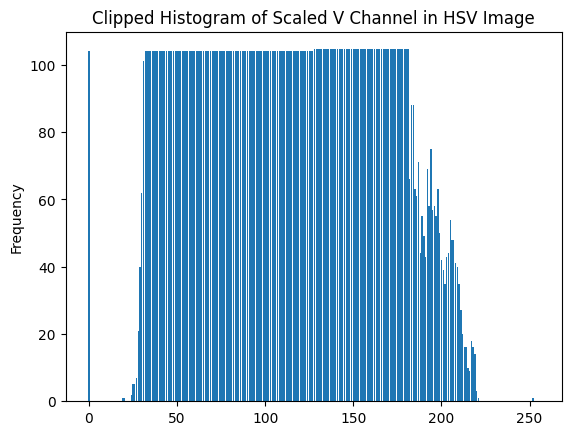

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
from numba import jit

@cuda.jit
def gpu_threshold_and_clip_histogram(d_histogram, d_threshold, histo_size):

  tid = cuda.threadIdx.x
  gridDim = cuda.gridDim.x * cuda.blockDim.x

  cuda.syncthreads()
  while tid < histo_size:
    if d_histogram[tid] > d_threshold[0]:
      d_histogram[tid] = d_threshold[0]
    tid += gridDim

histo_size = 256
np_type = np.uint8

v_channel = hsv_image[:, :, 2]
v_c = (v_channel.flatten() * 255).astype(np.uint8)

d_histogram = cuda.to_device(h_histogram)
d_threshold = cuda.to_device([threshold])

block_size = 128
grid_size = (histo_size + block_size - 1) // block_size

gpu_threshold_and_clip_histogram[grid_size, block_size](d_histogram, d_threshold, histo_size)

threshold = d_threshold.copy_to_host()

print('Threshold:', threshold)

clipped_histogram = np.clip(d_histogram.copy_to_host(), 0, threshold)

plt.bar(range(histo_size), clipped_histogram)
plt.title('Clipped Histogram of Scaled V Channel in HSV Image')
plt.ylabel('Frequency')

plt.show()


In [56]:
np.sum(h_histogram)/256

104.62109375

In [57]:
np.sum(h_histogram)

26783

## Histogram sub division and equalization

### divide 2 sub image

In [58]:
import numpy as np

def create_binary_arrays_from_v_channel(v_channel, threshold):

  v_channel_lower = np.zeros_like(v_channel, dtype=np.float32)
  v_channel_higher = np.zeros_like(v_channel, dtype=np.float32)

  for i in range(v_channel.shape[0]):
    for j in range(v_channel.shape[1]):
      if v_channel[i, j] < threshold/255:
        v_channel_lower[i, j] = v_channel[i, j]
      else:
        v_channel_higher[i, j] = v_channel[i, j]

  return v_channel_lower, v_channel_higher

In [59]:
v_channel_lower, v_channel_higher = create_binary_arrays_from_v_channel(v_channel, x_a)

In [60]:
v_channel.shape

(768, 551)

In [61]:
v_channel_lower.shape

(768, 551)

In [62]:
v_channel_higher.shape

(768, 551)

In [63]:
np.unique(v_channel_lower, return_counts = True)

(array([0.        , 0.05882353, 0.0627451 , 0.07058824, 0.07450981,
        0.07843138, 0.08235294, 0.08627451, 0.09019608, 0.09411765,
        0.09803922, 0.10196079, 0.10588235, 0.10980392, 0.11372549,
        0.11764706, 0.12156863, 0.1254902 , 0.12941177, 0.13333334,
        0.13725491, 0.14117648, 0.14509805, 0.14901961, 0.15294118,
        0.15686275, 0.16078432, 0.16470589, 0.16862746, 0.17254902,
        0.1764706 , 0.18039216, 0.18431373, 0.1882353 , 0.19215687,
        0.19607843, 0.2       , 0.20392157, 0.20784314, 0.21176471,
        0.21568628, 0.21960784, 0.22352941, 0.22745098, 0.23137255,
        0.23529412, 0.23921569, 0.24313726, 0.24705882, 0.2509804 ,
        0.25490198, 0.25882354, 0.2627451 , 0.26666668, 0.27058825,
        0.27450982, 0.2784314 , 0.28235295, 0.28627452, 0.2901961 ,
        0.29411766, 0.29803923, 0.3019608 , 0.30588236, 0.30980393,
        0.3137255 , 0.31764707, 0.32156864, 0.3254902 , 0.32941177,
        0.33333334, 0.3372549 , 0.34117648, 0.34

### calculate 2 sub cdf

#### upper

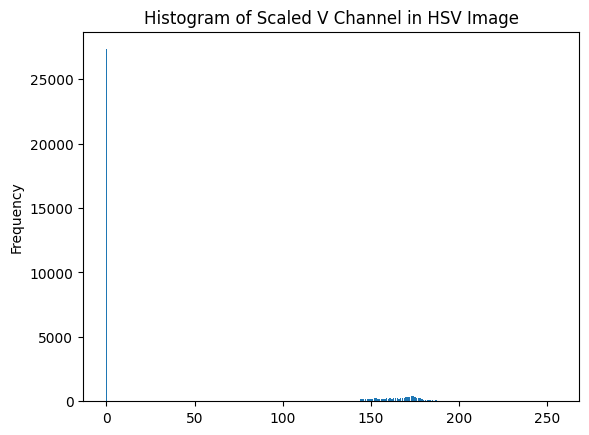

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda

# dr lilian code for histogram
@cuda.jit(device=True, cache=True)
def init_histogram(d_histogram):
    tid = cuda.threadIdx.x
    while tid < histo_size:
        d_histogram[tid] = 0
        tid += cuda.blockDim.x

@cuda.jit(device=True, cache=True)
def init_shared_memory(shared_memory):
    tid = cuda.threadIdx.x
    while tid < histo_size:
        shared_memory[tid] = 0
        tid += cuda.blockDim.x

@cuda.jit(device=True, cache=True)
def histo_op(pixel_value):
    return pixel_value // bin_width

@cuda.jit(device=True, cache=True)
def save_shared_memory(shared_memory, d_histo):
  tid = cuda.threadIdx.x
  cuda.syncthreads()
  while tid < histo_size:
    cuda.atomic.add(d_histo, tid, shared_memory[tid])
    tid += cuda.blockDim.x

@cuda.jit
def gpu_histogram(d_input, d_histogram):
  shared_memory = cuda.shared.array(shape=histo_size, dtype=np_type)
  init_histogram(d_histogram)
  init_shared_memory(shared_memory)

  tid = cuda.grid(1)
  gridDim = cuda.gridDim.x * cuda.blockDim.x
  while tid < d_input.size:
    bin = histo_op(d_input[tid])
    cuda.atomic.add(shared_memory, bin, 1)
    tid += gridDim

  save_shared_memory(shared_memory, d_histogram)

histo_size = 256
np_type = np.int64
bin_width = 1
v_channel_upper = v_channel_higher
upper = (v_channel_upper.flatten() * 255).astype(np.int64)

d_input = cuda.to_device(upper)
d_histogram = cuda.to_device(np.zeros(histo_size, dtype=np.int64))

block_size = 128
grid_size = (upper.size + block_size - 1) // block_size

gpu_histogram[grid_size, block_size](d_input, d_histogram)

h_histogram_upper = d_histogram.copy_to_host()

plt.bar(range(histo_size), h_histogram_upper)
plt.title('Histogram of Scaled V Channel in HSV Image')
plt.ylabel('Frequency')

plt.show()


In [65]:
np.unique(upper, return_counts = True)

(array([  0, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181,
        182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194,
        195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207,
        208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,
        221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 236, 237, 238, 239, 240, 241, 242, 243, 244, 246, 248, 249,
        250, 252, 253, 255]),
 array([236736,   2824,   2825,   2658,   2805,   2744,   2651,   2604,
          2605,   2649,   2619,   2484,   2532,   2585,   2542,   2448,
          2364,   2358,   2401,   2450,   2577,   2548,   2530,   2718,
          2718,   2865,   2899,   2968,   2935,   3165,   3262,   3290,
          3277,   3201,   3115,   3014,   3007,   2882,   2676,   2488,
          2478,   2400,   

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 2 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Threshold: [104.62109375]


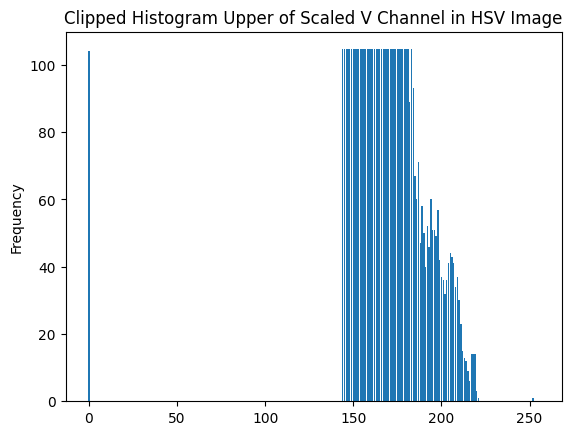

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
from numba import jit

@cuda.jit
def gpu_threshold_and_clip_histogram(d_histogram, d_threshold, histo_size):

  tid = cuda.threadIdx.x
  gridDim = cuda.gridDim.x * cuda.blockDim.x

  cuda.syncthreads()
  while tid < histo_size:
    if d_histogram[tid] > d_threshold[0]:
      d_histogram[tid] = d_threshold[0]
    tid += gridDim

histo_size = 256
np_type = np.uint8

v_channel = hsv_image[:, :, 2]
v_c = (v_channel.flatten() * 255).astype(np.uint8)

d_histogram = cuda.to_device(h_histogram_upper)
d_threshold = cuda.to_device(threshold)

block_size = 128
grid_size = (histo_size + block_size - 1) // block_size

gpu_threshold_and_clip_histogram[grid_size, block_size](d_histogram, d_threshold, histo_size)

threshold = d_threshold.copy_to_host()

print('Threshold:', threshold)

clipped_histogram_upper = np.clip(d_histogram.copy_to_host(), 0, threshold)

plt.bar(range(histo_size), clipped_histogram_upper)
plt.title('Clipped Histogram Upper of Scaled V Channel in HSV Image')
plt.ylabel('Frequency')

plt.show()


In [67]:
# ===================================================
@jit(nopython=True)
def calculate_cdf_new(hist):
    cdf = np.empty_like(hist, dtype=np.float64)
    cdf[0] = hist[0]

    for i in range(1, len(hist)):
        cdf[i] = cdf[i - 1] + hist[i]

    max_cdf = cdf[-1]

    for i in range(len(hist)):
        cdf[i] /= max_cdf

    return cdf

# cdf_result = calculate_cdf_new(h_histogram_new)
cdf_result_upper = calculate_cdf_new(clipped_histogram_upper)
print("Original Histogram:", h_histogram)
print("CDF Result Upper:", cdf_result_upper)

plt.plot(range(len(h_histogram)), cdf_result_upper)
plt.title('Normalized Cumulative Distribution Function (CDF)')
plt.xlabel('Pixel Value')
plt.ylabel('Normalized Cumulative Probability')

plt.show()

Original Histogram: [256   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   1   1   0   0   0   2   5   5   7  21  40  62 101 146 141 173 168
 170 170 111 123 141 137 124 129 123 150 116 121 160 126 128 136 152 140
 147 136 155 110 143 152 162 172 154 159 152 138 126 135 125 107 114 108
 107 109 104 105 107 109 112 117 122 124 151 141 131 153 138 133 149 147
 137 144 158 157 159 147 155 145 124 145 147 145 150 130 161 148 157 153
 150 164 167 167 159 145 154 173 159 159 143 148 145 137 153 137 144 128
 142 114 152 143 142 146 137 128 133 131 153 147 157 141 159 147 159 141
 184 167 179 207 190 234 219 224 254 275 239 262 243 230 185 241 176 237
 215 263 219 209 196 243 235 248 296 294 330 358 345 308 249 213 192 150
 128 107  66  88  88  63  61  71  44  55  49  43  69  58  75  57  58  55
  63  50  42  39  35  43  44  54  48  48  41  40  35  27  20  16  16  10
   9  18  16  14   3   1   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   

#### lower

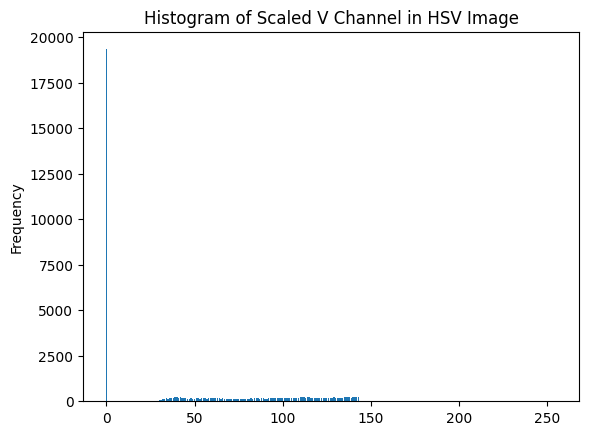

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda

# dr lilian code for histogram
@cuda.jit(device=True, cache=True)
def init_histogram(d_histogram):
    tid = cuda.threadIdx.x
    while tid < histo_size:
        d_histogram[tid] = 0
        tid += cuda.blockDim.x

@cuda.jit(device=True, cache=True)
def init_shared_memory(shared_memory):
    tid = cuda.threadIdx.x
    while tid < histo_size:
        shared_memory[tid] = 0
        tid += cuda.blockDim.x

@cuda.jit(device=True, cache=True)
def histo_op(pixel_value):
    return pixel_value // bin_width

@cuda.jit(device=True, cache=True)
def save_shared_memory(shared_memory, d_histo):
  tid = cuda.threadIdx.x
  cuda.syncthreads()
  while tid < histo_size:
    cuda.atomic.add(d_histo, tid, shared_memory[tid])
    tid += cuda.blockDim.x

@cuda.jit
def gpu_histogram(d_input, d_histogram):
  shared_memory = cuda.shared.array(shape=histo_size, dtype=np_type)
  init_histogram(d_histogram)
  init_shared_memory(shared_memory)

  tid = cuda.grid(1)
  gridDim = cuda.gridDim.x * cuda.blockDim.x
  while tid < d_input.size:
    bin = histo_op(d_input[tid])
    cuda.atomic.add(shared_memory, bin, 1)
    tid += gridDim

  save_shared_memory(shared_memory, d_histogram)

histo_size = 256
np_type = np.int64
bin_width = 1
v_channel_lower = v_channel_lower
lower = (v_channel_lower.flatten() * 255).astype(np.int64)

d_input = cuda.to_device(lower)
d_histogram = cuda.to_device(np.zeros(histo_size, dtype=np.int64))

block_size = 128
grid_size = (lower.size + block_size - 1) // block_size

gpu_histogram[grid_size, block_size](d_input, d_histogram)

h_histogram_lower = d_histogram.copy_to_host()

plt.bar(range(histo_size), h_histogram_lower)
plt.title('Histogram of Scaled V Channel in HSV Image')
plt.ylabel('Frequency')

plt.show()


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 2 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Threshold: [104.62109375]


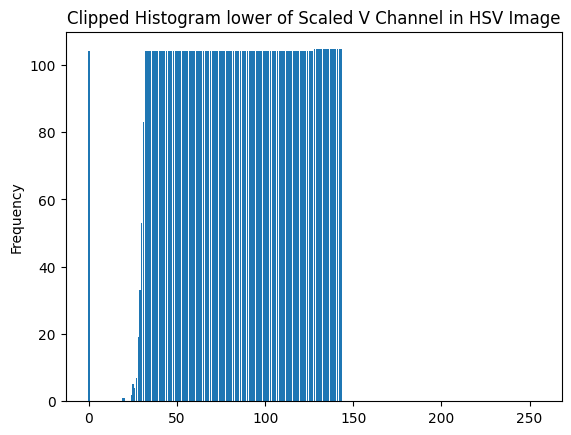

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
from numba import jit

@cuda.jit
def gpu_threshold_and_clip_histogram(d_histogram, d_threshold, histo_size):

  tid = cuda.threadIdx.x
  gridDim = cuda.gridDim.x * cuda.blockDim.x

  cuda.syncthreads()
  while tid < histo_size:
    if d_histogram[tid] > d_threshold[0]:
      d_histogram[tid] = d_threshold[0]
    tid += gridDim

histo_size = 256
np_type = np.uint8

v_channel = hsv_image[:, :, 2]
v_c = (v_channel.flatten() * 255).astype(np.uint8)

d_histogram = cuda.to_device(h_histogram_lower)
d_threshold = cuda.to_device(threshold)

block_size = 128
grid_size = (histo_size + block_size - 1) // block_size

gpu_threshold_and_clip_histogram[grid_size, block_size](d_histogram, d_threshold, histo_size)

threshold = d_threshold.copy_to_host()

print('Threshold:', threshold)

clipped_histogram_lower = np.clip(d_histogram.copy_to_host(), 0, threshold)

plt.bar(range(histo_size), clipped_histogram_lower)
plt.title('Clipped Histogram lower of Scaled V Channel in HSV Image')
plt.ylabel('Frequency')

plt.show()


Original Histogram: [256   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   1   1   0   0   0   2   5   5   7  21  40  62 101 146 141 173 168
 170 170 111 123 141 137 124 129 123 150 116 121 160 126 128 136 152 140
 147 136 155 110 143 152 162 172 154 159 152 138 126 135 125 107 114 108
 107 109 104 105 107 109 112 117 122 124 151 141 131 153 138 133 149 147
 137 144 158 157 159 147 155 145 124 145 147 145 150 130 161 148 157 153
 150 164 167 167 159 145 154 173 159 159 143 148 145 137 153 137 144 128
 142 114 152 143 142 146 137 128 133 131 153 147 157 141 159 147 159 141
 184 167 179 207 190 234 219 224 254 275 239 262 243 230 185 241 176 237
 215 263 219 209 196 243 235 248 296 294 330 358 345 308 249 213 192 150
 128 107  66  88  88  63  61  71  44  55  49  43  69  58  75  57  58  55
  63  50  42  39  35  43  44  54  48  48  41  40  35  27  20  16  16  10
   9  18  16  14   3   1   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   

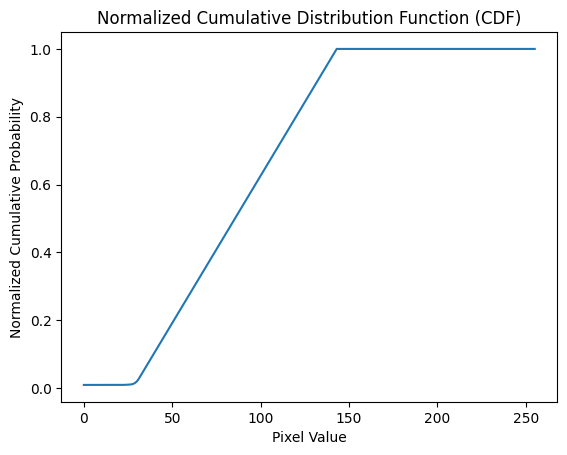

In [70]:
# ===================================================
@jit(nopython=True)
def calculate_cdf_new(hist):
    cdf = np.empty_like(hist, dtype=np.float64)
    cdf[0] = hist[0]

    for i in range(1, len(hist)):
        cdf[i] = cdf[i - 1] + hist[i]

    max_cdf = cdf[-1]

    for i in range(len(hist)):
        cdf[i] /= max_cdf

    return cdf

# cdf_result = calculate_cdf_new(h_histogram_new)
cdf_result_lower = calculate_cdf_new(clipped_histogram_lower)
print("Original Histogram:", h_histogram)
print("CDF Result lower:", cdf_result_lower)

plt.plot(range(len(h_histogram)), cdf_result_lower)
plt.title('Normalized Cumulative Distribution Function (CDF)')
plt.xlabel('Pixel Value')
plt.ylabel('Normalized Cumulative Probability')

plt.show()

### map the image back

/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:886: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


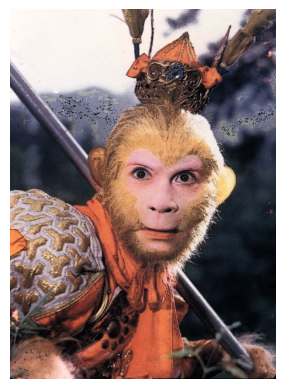

In [71]:
@cuda.jit
def map_to_cdf_kernel(v_channel, cdf_result_lower, cdf_result_upper, histo_size, x_a, result):
    id = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x

    if id < len(v_channel):
      if v_channel[id] < x_a[0]:
        result[id] = cdf_result_lower[v_channel[id]]*(x_a[0]/histo_size) if cdf_result_lower[v_channel[id]]*(x_a[0]/histo_size) < 1 else 1
      elif v_channel[id] > x_a[0]:
        result[id] = cdf_result_upper[v_channel[id]]*((histo_size - x_a[0] + 1)/histo_size) + (x_a[0] + 1)/histo_size if cdf_result_upper[v_channel[id]]*((histo_size - x_a[0] + 1)/histo_size) + (x_a[0] + 1)/histo_size < 1 else 1

block_size = 128
v_c = (v_channel.flatten() * 255).astype(np.uint8)
grid_size = (len(v_c) + block_size - 1) // block_size


d_input = cuda.to_device(v_c)
cdf_lower = cuda.to_device(cdf_result_lower)
cdf_upper = cuda.to_device(cdf_result_upper)
d_histo_size = cuda.to_device(histo_size)
d_x_a = cuda.to_device(x_a)
result_np = cuda.to_device(np.zeros(len(v_c), dtype=np.float32))

map_to_cdf_kernel[grid_size, block_size](d_input, cdf_lower, cdf_upper, histo_size, d_x_a, result_np)

result_v = result_np.copy_to_host()
result_v_new = result_v.reshape(hsv_image[:,:,2].shape)

hsv_image[:, :, 2] = result_v_new

# hsv to rgb
hsv_image_flat = hsv_image.reshape(pixel_count, 3)

start_time_gpu = time.time()
devDst2 = cuda.device_array((pixel_count, 3), np.uint8)
hsv2rgb[gridSize, blockSize](hsv_image_flat, devDst2)
hostDst = devDst2.copy_to_host()
gpu_time = time.time() - start_time_gpu

new_image_rgb = hostDst.reshape(imageWidth, imageHeight, 3)
plt.imshow(new_image_rgb)
plt.axis('off')
plt.show()

In [72]:
time.time() - start_time

9.610027313232422

## EIHE metrics

In [73]:
# AME (Average Mean Error)

@cuda.jit
def calculate_ame(image1, image2, result):
  id = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x

  if id < image1.size:
    abs_diff = image1[id] - image2[id]
    if abs_diff < 0:
      abs_diff = -abs_diff
    result[id] = abs_diff

d_v_result = cuda.to_device(result_v)
v_c = (v_channel.flatten() * 255).astype(np.int64)
d_v_origin = cuda.to_device(v_c)
result_np = cuda.to_device(np.zeros(len(d_v_result), dtype=np.float32))

calculate_ame[grid_size, block_size](d_v_result, d_v_origin, result_np)

result_ame = result_np.copy_to_host()

In [74]:
from __future__ import annotations

import numpy as np
from numba.np.numpy_support import from_dtype
from numba import cuda, core


class AssociativeReduce(object):
    """Create a reduction object that reduces values using a given binary
    function. The binary function is compiled once and cached inside this
    object. Keeping this object alive will prevent re-compilation.
    """

    _cache = {}

    _WARP_SIZE = 32
    _NUM_WARPS = 8

    @staticmethod
    def _gpu_kernel_factory(fn, np_type):
        """Factory of kernels for the reduction problem...

        This function returns a Cuda Kernel that does the reduction of some data using a given binary functor."""

        reduce_op = cuda.jit(device=True)(fn)

        max_block_size = AssociativeReduce._NUM_WARPS * AssociativeReduce._WARP_SIZE

        @cuda.jit(device=True)
        def load_shared_memory(shared_memory, arr, null_value):
            global_tid = cuda.grid(1)
            local_tid = cuda.threadIdx.x
            # TODO: same as first exercise
            shared_memory[local_tid] = arr[global_tid] if global_tid < arr.size else null_value
            # wait all warps
            cuda.syncthreads()

        @cuda.jit(device=True)
        def reduce_per_warp(shared_memory):
            # warp_id = cuda.threadIdx.x // 32
            # in_warp_id = cuda.threadIdx.x % 32
            # # TODO: implement the pointer jumping without synchronization
            # # if right < max_block_size: # or cuda.blockDim.x
            # #   temp = shared_memory[right]
            # # else:
            # #   temp = shared_memory[local_tid]
            # # cuda.syncthreads()

            # temp = shared_memory[32*warp_id + in_warp_id]

            # # if right < max_block_size:
            # #   shared_memory[local_tid] = reduce_op(shared_memory[local_tid], temp)

            # shared_memory[32*warp_id + in_warp_id] = reduce_op(shared_memory[32*warp_id + in_warp_id], temp)
            # # cuda.syncthreads()

            tid = cuda.threadIdx.x
            in_warp_id = tid & 31 # what does this mean | chia lay du?

            jump = 1

            while jump < 32: # less than the side of the warp
              if in_warp_id + jump < 32:
                temp = shared_memory[tid+jump]
              cuda.syncwarp() # not syncthread but warp |
              if in_warp_id + jump < 32:
                shared_memory[tid] = reduce_op(shared_memory[tid], temp)
              cuda.syncwarp()
              jump = jump * 2


        def gpu_reduce_block(arr, partials, null_value):
            """
            Per block reduction, basic version...
            """
            # move data to shared memory
            shared_memory = cuda.shared.array(shape=max_block_size, dtype=np_type)
            load_shared_memory(shared_memory, arr, null_value)

            # TODO: implements the logics
            reduce_per_warp(shared_memory)
            cuda.syncthreads()

            if cuda.threadIdx.x >= 32: return

            to_warp = cuda.threadIdx.x * 32 # each 0 idx in each warp has the distance of 32

            shared_memory[cuda.threadIdx.x] = shared_memory[to_warp] if to_warp < cuda.blockDim.x else null_value # blockDim

            reduce_per_warp(shared_memory)
            # now stores the result
            if cuda.threadIdx.x == 0:
                blk_id = cuda.blockIdx.x
                partials[blk_id] = shared_memory[0]

        return cuda.jit(gpu_reduce_block)

    def __init__(self, functor):
        """
        :param functor: A function implementing a binary operation for
                        reduction. It will be compiled as a CUDA device
                        function using ``cuda.jit(device=True)``.
        """
        self._functor = functor

    def _compile(self, dtype):
        key = self._functor, dtype
        if key not in self._cache:
            self._cache[key] = AssociativeReduce._gpu_kernel_factory(self._functor, from_dtype(dtype))
        return self._cache[key]

    def __call__(self, arr, null_value, res=None, stream=cuda.default_stream()):
        """Performs a full reduction.

        :param arr: A host or device array.
        :param null_value: zero value for array.dtype
        :param res: Device array into which to write the reduction
                    result to. The result is written into the first element of
                    this array if this array is provided.
        :param stream: Optional CUDA stream in which to perform the reduction.
                    If no stream is specified, the default stream of 0 is
                    used.
        """

        # ensure 1d array
        if arr.ndim != 1:
            raise TypeError("only support 1D array")

        # ensure size > 0
        if arr.size < 1:
            raise ValueError("array's length is 0")

        _sav, core.config.CUDA_LOW_OCCUPANCY_WARNINGS = core.config.CUDA_LOW_OCCUPANCY_WARNINGS, False

        kernel = self._compile(arr.dtype)

        # Perform the reduction on the GPU
        start_event = cuda.event(True)
        start_event.record(stream=stream)
        nb_threads = self._NUM_WARPS * self._WARP_SIZE
        #=================================
        # the computation is different so we need this part:
        if True:
          if nb_threads > arr.size:
            nb_threads = arr.size
          nb_blocks = (arr.size + nb_threads - 1) // nb_threads

          temp = cuda.device_array(shape=nb_blocks, dtype=arr.dtype, stream=stream)
          kernel[nb_blocks, nb_threads, stream](arr, temp, null_value)
        # Perform the reduction on the GPU
        start_event = cuda.event(True)
        start_event.record(stream=stream)
        #=================================
        while True:
            if nb_threads > arr.size:
                nb_threads = arr.size

            nb_blocks = (arr.size + nb_threads - 1) // nb_threads

            temp = cuda.device_array(shape=nb_blocks, dtype=arr.dtype, stream=stream)

            kernel[nb_blocks, nb_threads, stream](arr, temp, null_value)
            print(f"launch {nb_blocks} for {nb_threads * nb_blocks} threads")
            cuda.synchronize()
            arr = temp
            if nb_blocks == 1:
                break

        stop_event = cuda.event(True)
        stop_event.record(stream=stream)
        stop_event.synchronize()
        ct = cuda.event_elapsed_time(start_event, stop_event)
        print(f"kernel computation time is {ct} ms")

        # handle return value
        if res is not None:
            res.copy_to_device(arr)

        core.config.CUDA_LOW_OCCUPANCY_WARNINGS = _sav

        return arr.copy_to_host(stream=stream)[0]


reducer = AssociativeReduce(lambda a, b: a + b)
h_array = result_ame
result = reducer(cuda.to_device(h_array), np.float32(0.0))
result

launch 1653 for 423168 threads
launch 7 for 1792 threads
launch 1 for 7 threads
kernel computation time is 2.9751999378204346 ms


58835944.0

In [75]:
import numpy as np

def calculate_entropy(hist):

  entropy = 0.0
  for i in range(len(hist)):
    if hist[i] > 0:
      entropy += hist[i] * np.log2(hist[i])

  return -entropy

import numpy as np

def calculate_entropy_using_pdf(hist):

  pdf = hist / hist.sum()

  pdf[pdf == 0] = 1e-15

  entropy = 0.0
  for i in range(len(hist)):
    entropy += pdf[i] * np.log2(pdf[i])

  return -entropy

entropy = calculate_entropy_using_pdf(clipped_histogram)

print("Entropy:", entropy)

Entropy: 7.525870571017801
